## This notebook is for dev purposes only
##### See demo.ipynb for function usage

In [1]:
import numpy as np
import pandas as pd
import warnings

from random import randint
from tqdm.autonotebook import tqdm
from functools import partial

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ML algo
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


#### Note: Someone please write the documentation ;)

In [2]:
class MLModels2():
    # safe to change
    n_trials = 50
    random_state = None
    pred_var_setting = 0.01
    
    # not so safe to change
    model = None
    _setting_name = None
    
    def __init__(self):
        self.training_accuracy = None
        self.test_accuracy = None
        self.training_std = None
        self.test_std = None
        self.coef = None
        
    def plot_accuracy(self):
        fig, ax = plt.subplots()
        ax.plot(self._setting, self.training_accuracy, label="training accuracy")
        ax.plot(self._setting, self.test_accuracy, label="test accuracy")
        ax.fill_between(self._setting, self.training_accuracy-self.training_std, self.training_accuracy+self.training_std, alpha=0.2)
        ax.fill_between(self._setting, self.test_accuracy-self.test_std, self.test_accuracy+self.test_std, alpha=0.2)
        ax.set_ylabel("Accuracy")
        ax.set_xlabel(self._setting_name)
        ax.legend()
        return ax
        
    def train_test(self, X, y):
        train_accuracies = []
        test_accuracies = []
        if self.pred_var_setting is not None:
            self._setting = sorted(list(set(self._setting).union({self.pred_var_setting})))
        with tqdm(total=self.n_trials*len(self._setting)) as pb:
            for i in range(self.n_trials):
                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=self.random_state)
                pb.set_description(f'Iter: {i + 1}')
                training_accuracy = []
                test_accuracy = []
                feature_coef = []
                for s in self._setting:
                    # build the model
                    clf = self.model(**{self._setting_name: s})
                    clf.fit(X_train, y_train)
                    # record training set accuracy
                    training_accuracy.append(clf.score(X_train, y_train))
                    # record generalization accuracy
                    test_accuracy.append(clf.score(X_test, y_test))
                    if s == self.pred_var_setting:
                        try:
                            feature_coef.append(clf.coef_)
                        except AttributeError:
                            pass
                    pb.update(1)
                    
                train_accuracies.append(training_accuracy)
                test_accuracies.append(test_accuracy)

        self.training_accuracy = np.mean(train_accuracies, axis=0)
        self.test_accuracy = np.mean(test_accuracies, axis=0)
        self.training_std = np.std(train_accuracies, axis=0)
        self.test_std = np.std(test_accuracies, axis=0)
        if feature_coef:
            self.coef = np.mean(feature_coef, axis=0)
            
    def run_classifier(X, labels, feature_names=None, algorithm='all'):
        alpha = [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20]
        C = [1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
        n_nb = list(range(1, 51))
        
        if algorithm == 'all':
            methods = {
                'KNN': KNNClassifier(n_nb),
                'Logistic Regression (L1)': LogisticRegressor(C, 'l1'),
                'Logistic Regression (L2)': LogisticRegressor(C, 'l2'),
                'SVC (L1)': LinearSVM(C, 'l1'),
                'SVC (L2)': LinearSVM(C, 'l2')
            }
        else:
            methods = {}
            for algo in algorithm:
                if algo == 'KNN':
                    methods[algo] = KNNClassifier(n_nb)
                elif algo == 'Logistic Regression':
                    methods['Logistic Regression (L1)'] = LogisticRegressor(C, 'l1')
                    methods['Logistic Regression (L2)'] = LogisticRegressor(C, 'l2')
                elif algo == 'SVC':
                    methods['SVC (L1)'] = LinearSVM(C, 'l1')
                    methods['SVC (L2)'] = LinearSVM(C, 'l2')
        
        print(methods)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            for k in methods:
                print(k)
                m = methods[k]
                m.train_test(X, labels)
                
        print(MLModels.summarize(methods, feature_names if feature_names is not None else X.columns))
        return methods
    
    def summarize(methods, feature_names=None):
        names = []
        accuracies = []
        parameters = []
        features = []
        for k in methods:
            m = methods[k]
            names.append(k)
            accuracies.append(np.max(m.test_accuracy))
            parameters.append('%s = %s' % (m._setting_name, m._setting[np.argmax(m.test_accuracy)]))
            if m.coef is not None:
                features.append(feature_names[np.argmax(m.coef)])
            else:
                features.append('None')
        
        return pd.DataFrame(zip(names, accuracies, parameters, features), columns=['Model', 'Accuracy', 'Parameter', 'Feature'])

class KNN(MLModels):
    _setting_name = 'n_neighbors'
    pred_var_setting = None
   
    def __init__(self, neighbor_setting):
        super().__init__()
        self._setting = neighbor_setting
    
class KNNClassifier(KNN):
    model = KNeighborsClassifier

class KNNRegressor(KNN):
    model = partial(KNeighborsRegressor, algorithm='kd_tree')

class LinearRegressor(MLModels):
    model = None
    _setting_name = 'alpha'
    
    def __init__(self, alpha):
        super().__init__()
        self._setting = alpha
        
class LassoRegressor(LinearRegressor):
    model = partial(Lasso, max_iter=10000)
    
class RidgeRegressor(LinearRegressor):
    model = Ridge

class LinearClassifier(LinearRegressor):
    model = None
    _setting_name = 'C'
    
    def __init__(self, C, reg='l2'):
        self._setting = C
        self._init_model(reg)
        
    def _init_model(self, reg):
        raise NotImplementedError()
    
class LogisticRegressor(LinearClassifier):
    def _init_model(self, reg):
        self.model = partial(LogisticRegression, solver='liblinear', penalty=reg)
        
class LinearSVM(LinearClassifier):
    def _init_model(self, reg):
        self.model = partial(LinearSVC, loss='squared_hinge', dual=False, penalty=reg)

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [4]:
MLModels.n_trials = 5 # Change n_trials for all models
m = MLModels.run_classifier(cancer.data, cancer.target, cancer.feature_names)

KNN



Logistic Regression (L1)



Logistic Regression (L2)



SVC (L1)



SVC (L2)



                      Model  Accuracy         Parameter         Feature
0                       KNN  0.932867  n_neighbors = 10            None
1  Logistic Regression (L1)  0.969231          C = 1000  mean perimeter
2  Logistic Regression (L2)  0.967832          C = 1000  mean perimeter
3                  SVC (L1)  0.966434            C = 15  mean perimeter
4                  SVC (L2)  0.960839           C = 300    worst radius


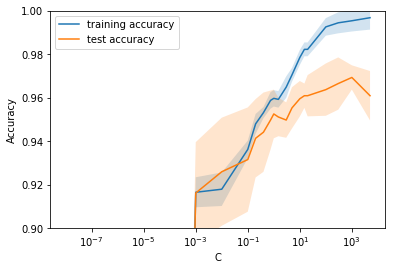

In [5]:
ax = m['Logistic Regression (L1)'].plot_accuracy()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

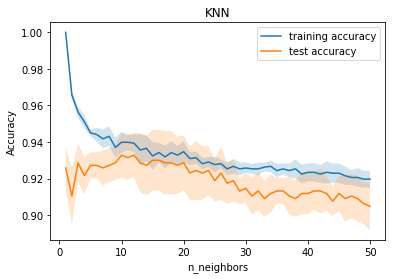

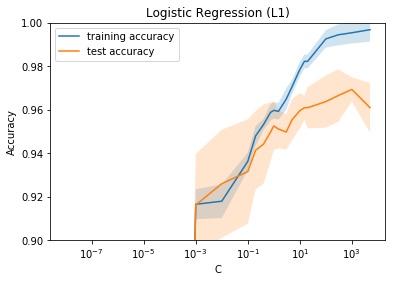

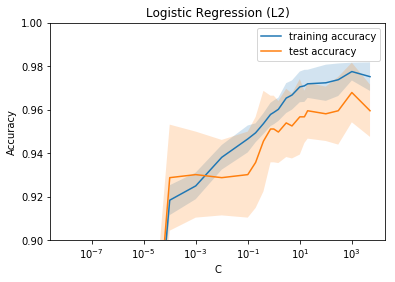

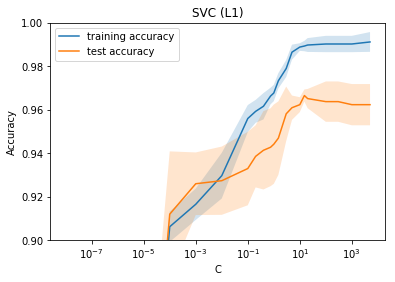

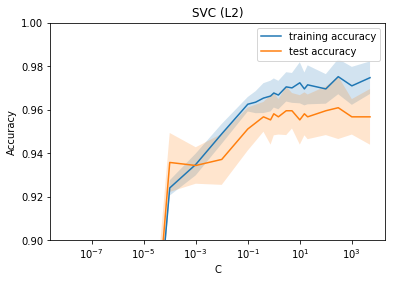

In [9]:
for k in m:
    ax = m[k].plot_accuracy()
    ax.set_title(k)
    if k != 'KNN':
        ax.set_ylim(0.9, 1)
        ax.set_xscale('log')

## Scratch below this line

In [ ]:
knn = LassoRegressor(alpha)
knn.n_trials = 1
m = knn.calculate_accuracy(df, targets)

In [ ]:
knn.plot_test_train()

In [ ]:
knn.top_pred

In [ ]:
knn.coef

In [ ]:
np.argmax(np.abs(knn.coef))

In [ ]:
df.columns

In [ ]:
dict(knn.coef)

In [ ]:
hasattr()

In [ ]:
df = pd.read_excel('parkinsons_updrs.xlsx')

In [ ]:
targets = df.loc[:, 'Target']
df.drop('Target', axis=1, inplace=True)

In [ ]:
knn = KNNRegressor(range(1, 10, 1))
knn.n_trials = 5

In [ ]:
knn.calculate_accuracy(df, targets)

In [ ]:
knn.plot_test_train()

In [ ]:
alpha = [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20]

In [ ]:
lr = LassoRegressor(alpha)
lr.n_trials = 5

In [ ]:
lr.calculate_accuracy(df, targets)

In [ ]:
lr.plot_test_train()

In [ ]:
rr = RidgeRegressor(alpha)
rr.n_trials = 5

In [ ]:
rr.calculate_accuracy(df, targets)

In [ ]:
{1}.union({2})

In [ ]:
rr.plot_test_train()

In [ ]:
rr.model

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [ ]:
n_nb = list(range(1, 51))

In [ ]:
knnc = KNNClassifier(n_nb)

In [ ]:
knnc.calculate_accuracy(cancer.data, cancer.target)

In [ ]:
knnc.plot_test_train()

In [ ]:
C = [1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

In [ ]:
logr = LogisticRegressor(C)
# logr.n_trials = 2

In [ ]:
logr.calculate_accuracy(cancer.data, cancer.target)

In [ ]:
cancer.feature_names[np.argmax(logr.coef)]

In [ ]:
ax = logr.plot_test_train()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

In [ ]:
logr1 = LogisticRegressor(C, 'l1')

In [ ]:
logr1.calculate_accuracy(cancer.data, cancer.target)

In [ ]:
ax = logr1.plot_test_train()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

In [ ]:
np.max(logr1.test_accuracy)

In [ ]:
C[np.argmax(logr1.test_accuracy)]

In [ ]:
cancer.feature_names[np.argmax(logr1.coef)]

In [ ]:
svc = LinearSVM(C, 'l1')
svc.calculate_accuracy(cancer.data, cancer.target)

In [ ]:
ax = svc.plot_test_train()
ax.set_ylim(0.9, 1)
ax.set_xscale('log')

In [ ]:
cancer.feature_names[np.argmax(svc.coef)]

In [ ]:
alpha = [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20]
C = [1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
n_nb = list(range(1, 51))
methods = {
    'KNN': KNNClassifier(n_nb),
    'Logistic Regression (L1)': LogisticRegressor(C, 'l1'),
    'Logistic Regression (L2)': LogisticRegressor(C, 'l2'),
    'SVC (L1)': LinearSVM(C, 'l1'),
    'SVC (L2)': LinearSVM(C, 'l2')
}

In [ ]:
import warnings

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    names = []
    accuracies = []
    parameters = []
    features = []
    for k in methods:
        print(k)
        m = methods[k]
        m.n_trials = 2
        m.calculate_accuracy(cancer.data, cancer.target)
        
        names.append(k)
        accuracies.append(np.max(m.test_accuracy))
        parameters.append('%s = %s' % (m.setting_title, m.setting[np.argmax(m.test_accuracy)]))
        features.append(cancer.feature_names[np.argmax(m.coef)])

In [ ]:
pd.DataFrame(zip(names, accuracies, parameters, features), columns=['Model', 'Accuracy', 'Parameter', 'Feature'])